## 1. Importing Libraries

In [2]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    MinMaxScaler,
    StandardScaler,
    PowerTransformer,
    FunctionTransformer
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

from feature_engine.outliers import Winsorizer
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder    
)
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance

from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

import warnings

## 2. Display Settings

In [3]:
# for displaying all the columns 
pd.set_option("display.max_columns", None)

In [4]:
# for getting the output as a pandas dataframe and not as a numpy array from the scikitlearn transformers
sklearn.set_config(transform_output = "pandas")

In [5]:
warnings.filterwarnings('ignore')

## 3. Read the Data

In [6]:
file_path = "/Users/subhadeepchoudhury/Desktop/flight-price-prediction/data/train.csv"

train = pd.read_csv("/Users/subhadeepchoudhury/Desktop/flight-price-prediction/data/train.csv")

train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,New Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,2019-03-09,Banglore,New Delhi,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,New Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included,11087
...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,2019-03-21,Delhi,Cochin,10:45:00,18:50:00,1925,2.0,No Info,11093
6691,Air India,2019-05-01,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8891
6692,Jet Airways,2019-06-01,Delhi,Cochin,14:00:00,19:00:00,300,1.0,In-flight meal not included,10262
6693,Air Asia,2019-06-24,Delhi,Cochin,07:55:00,13:25:00,330,1.0,No Info,6152


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6695 non-null   object 
 1   date_of_journey  6695 non-null   object 
 2   source           6695 non-null   object 
 3   destination      6695 non-null   object 
 4   dep_time         6695 non-null   object 
 5   arrival_time     6695 non-null   object 
 6   duration         6695 non-null   int64  
 7   total_stops      6694 non-null   float64
 8   additional_info  6695 non-null   object 
 9   price            6695 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 523.2+ KB


In [8]:
# Splitting the dataset into features (X_train) and target variable (y_train)
# Dropping the 'price' column from the training data to create the feature set
X_train = train.drop(columns="price", axis=1)

# Copying the 'price' column to create the target variable
y_train = train.price.copy()

## 4. Transformation Operations

In [9]:
X_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

### 4.1 airline

In [10]:
X_train.airline

0       Jet Airways
1       Jet Airways
2             Goair
3         Air India
4       Jet Airways
           ...     
6690    Jet Airways
6691      Air India
6692    Jet Airways
6693       Air Asia
6694      Air India
Name: airline, Length: 6695, dtype: object

In [11]:
X_train.airline.value_counts(normalize = True)

airline
Jet Airways          0.357132
Indigo               0.193577
Air India            0.160717
Multiple Carriers    0.109933
Spicejet             0.080209
Vistara              0.048096
Air Asia             0.031516
Goair                0.018671
Trujet               0.000149
Name: proportion, dtype: float64

### What is a Pipeline?
A pipeline is a sequence of data processing steps chained together, where each step is a transformer or an estimator. It automates workflows by applying preprocessing steps and model training in a consistent manner. In scikit-learn, the `Pipeline` class is used to define such workflows, ensuring that data transformations are applied systematically and reducing the risk of data leakage.
- Also remember that it is a list of tuples 

In [12]:
# Creating a pipeline for the 'airline' column
# The pipeline consists of three steps:
# 1. Imputation: Filling missing values with the most frequent value in the column.
# 2. Rare Label Encoding: Grouping infrequent categories into a single category called "Other".
# 3. One-Hot Encoding: Converting categorical variables into a one-hot numeric array.
air_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

# Applying the pipeline to the 'airline' column of the training data
# This will transform the column based on the steps defined in the pipeline
air_transformer.fit_transform(X_train.loc[:, ["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
6690,0.0,0.0,1.0,0.0,0.0
6691,1.0,0.0,0.0,0.0,0.0
6692,0.0,0.0,1.0,0.0,0.0
6693,0.0,0.0,0.0,0.0,1.0


### 4.2 date_of_journey

In [13]:
X_train.date_of_journey

0       2019-03-21
1       2019-03-27
2       2019-03-09
3       2019-06-12
4       2019-03-12
           ...    
6690    2019-03-21
6691    2019-05-01
6692    2019-06-01
6693    2019-06-24
6694    2019-03-01
Name: date_of_journey, Length: 6695, dtype: object

In [14]:
feature_to_extract = ["month","week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps = [
    ("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
    ("scale", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.176471,0.500000,0.169492
1,0.000000,0.235294,0.333333,0.220339
2,0.000000,0.058824,0.833333,0.067797
3,1.000000,0.882353,0.333333,0.872881
4,0.000000,0.117647,0.166667,0.093220
...,...,...,...,...
6690,0.000000,0.176471,0.500000,0.169492
6691,0.666667,0.529412,0.333333,0.516949
6692,1.000000,0.764706,0.833333,0.779661
6693,1.000000,1.000000,0.000000,0.974576


In [15]:
(
    X_train
    .assign(
        date_of_journey = pd.to_datetime(X_train.date_of_journey)
    )
    .date_of_journey
    .dt.year
    .value_counts()
)

date_of_journey
2019    6695
Name: count, dtype: int64

### 4.3 source and destination

In [16]:
X_train.source

0       Banglore
1          Delhi
2       Banglore
3        Kolkata
4       Banglore
          ...   
6690       Delhi
6691     Kolkata
6692       Delhi
6693       Delhi
6694    Banglore
Name: source, Length: 6695, dtype: object

In [17]:
X_train.destination

0       New Delhi
1          Cochin
2       New Delhi
3        Banglore
4       New Delhi
          ...    
6690       Cochin
6691     Banglore
6692       Cochin
6693       Cochin
6694    New Delhi
Name: destination, Length: 6695, dtype: object

In [18]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Banglore,New Delhi
1,Delhi,Cochin
2,Banglore,New Delhi
3,Kolkata,Banglore
4,Banglore,New Delhi
...,...,...
6690,Delhi,Cochin
6691,Kolkata,Banglore
6692,Delhi,Cochin
6693,Delhi,Cochin


In [19]:
location_pipe1 = Pipeline(steps = [
    ('grouper', RareLabelEncoder(tol= 0.1, replace_with="other", n_categories= 2 )),
    ('encoder', MeanEncoder()),
    ("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,-0.857930,-0.736484
1,1.065418,1.061694
2,-0.857930,-0.736484
3,-0.203928,-0.224351
4,-0.857930,-0.736484
...,...,...
6690,1.065418,1.061694
6691,-0.203928,-0.224351
6692,1.065418,1.061694
6693,1.065418,1.061694


In [20]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [21]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
    return (
        X
        .assign(**{
            f"{col}_is_north" : X.loc[:, col].isin(north_cities).astype(int)
            for col in columns 
        })
        .drop(columns = columns)
    )

# is_north(location_subset)

FunctionTransformer(func = is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,0,1
1,1,0
2,0,1
3,1,0
4,0,1
...,...,...
6690,1,0
6691,1,0
6692,1,0
6693,1,0


In [22]:
location_transformer = FeatureUnion(transformer_list= [
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func = is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,-0.857930,-0.736484,0,1
1,1.065418,1.061694,1,0
2,-0.857930,-0.736484,0,1
3,-0.203928,-0.224351,1,0
4,-0.857930,-0.736484,0,1
...,...,...,...,...
6690,1.065418,1.061694,1,0
6691,-0.203928,-0.224351,1,0
6692,1.065418,1.061694,1,0
6693,1.065418,1.061694,1,0


In [23]:
location_transformer

FeatureUnion(transformer_list=[('part1',
                                Pipeline(steps=[('grouper',
                                                 RareLabelEncoder(n_categories=2,
                                                                  replace_with='other',
                                                                  tol=0.1)),
                                                ('encoder', MeanEncoder()),
                                                ('scaler',
                                                 PowerTransformer())])),
                               ('part2',
                                FunctionTransformer(func=<function is_north at 0x1417d8900>))])

### 4.4 dep_time and arrival_time

In [24]:
train.dep_time

0       08:55:00
1       17:30:00
2       11:40:00
3       09:25:00
4       22:55:00
          ...   
6690    10:45:00
6691    09:25:00
6692    14:00:00
6693    07:55:00
6694    11:50:00
Name: dep_time, Length: 6695, dtype: object

In [25]:
train.arrival_time

0       19:10:00
1       04:25:00
2       14:35:00
3       18:30:00
4       07:40:00
          ...   
6690    18:50:00
6691    18:30:00
6692    19:00:00
6693    13:25:00
6694    08:55:00
Name: arrival_time, Length: 6695, dtype: object

In [26]:
time_subset = train.loc[:,['dep_time','arrival_time']]
display(time_subset)

,dep_time,arrival_time
0,08:55:00,19:10:00
1,17:30:00,04:25:00
2,11:40:00,14:35:00
3,09:25:00,18:30:00
4,22:55:00,07:40:00
...,...,...
6690,10:45:00,18:50:00
6691,09:25:00,18:30:00
6692,14:00:00,19:00:00
6693,07:55:00,13:25:00


In [27]:
time_pipe1 = Pipeline(steps =[
    ("dt", DatetimeFeatures(features_to_extract=['hour', 'minute'])),
    ("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.347826,1.000000,0.826087,0.181818
1,0.739130,0.545455,0.173913,0.454545
2,0.478261,0.727273,0.608696,0.636364
3,0.391304,0.454545,0.782609,0.545455
4,0.956522,1.000000,0.304348,0.727273
...,...,...,...,...
6690,0.434783,0.818182,0.782609,0.909091
6691,0.391304,0.454545,0.782609,0.545455
6692,0.608696,0.000000,0.826087,0.000000
6693,0.304348,1.000000,0.565217,0.454545


In [28]:
def part_of_day(X, morning = 4, noon = 12, eve = 16, night = 20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col : pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns
    })
    
    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day" : np.select(
                [X_temp.loc[:,col].between(morning, noon, inclusive = "left"),
                 X_temp.loc[:,col].between(noon, eve, inclusive = "left"),
                 X_temp.loc[:,col].between(eve, night, inclusive = "left")],
                ["morning", "afternoon", "evening"],
                default = "night"
            )
            for col in columns
        })
        .drop(columns = columns)
    )

FunctionTransformer(func = part_of_day).fit_transform(time_subset)
    

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,evening
1,evening,morning
2,morning,afternoon
3,morning,evening
4,night,morning
...,...,...
6690,morning,evening
6691,morning,evening
6692,afternoon,evening
6693,morning,afternoon


In [29]:
time_pipe2 = Pipeline(steps = [
    ('part_of_day', FunctionTransformer(func = part_of_day)), 
    ('encoder', CountFrequencyEncoder()),
    ("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.667335
1,0.202685,0.952906
2,1.000000,0.000000
3,1.000000,0.667335
4,0.174101,0.952906
...,...,...
6690,1.000000,0.667335
6691,1.000000,0.667335
6692,0.000000,0.667335
6693,1.000000,0.000000


In [30]:
time_transformer = FeatureUnion(transformer_list= [
    ('part1', time_pipe1),
    ("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.347826,1.000000,0.826087,0.181818,1.000000,0.667335
1,0.739130,0.545455,0.173913,0.454545,0.202685,0.952906
2,0.478261,0.727273,0.608696,0.636364,1.000000,0.000000
3,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335
4,0.956522,1.000000,0.304348,0.727273,0.174101,0.952906
...,...,...,...,...,...,...
6690,0.434783,0.818182,0.782609,0.909091,1.000000,0.667335
6691,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335
6692,0.608696,0.000000,0.826087,0.000000,0.000000,0.667335
6693,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000


### 4.5 duration

In [31]:
X_train.duration

0        615
1        655
2        175
3        545
4        525
        ... 
6690    1925
6691     545
6692     300
6693     330
6694    1265
Name: duration, Length: 6695, dtype: int64

In [32]:
def duration_categories(X):
    return (
        X
        .assign(duration_category = np.select(
                [X.loc[:,"duration"].between(0, 180, inclusive = "left"),
                X.loc[:,"duration"].between(180, 400, inclusive = "left")],
                ["short", "medium"],
                default = "long"
            )
        )
        .drop(columns = ["duration"])
    )

FunctionTransformer(func = duration_categories).fit_transform(X_train[['duration']])

,duration_category
0,long
1,long
2,short
3,long
4,long
...,...
6690,long
6691,long
6692,medium
6693,medium


In [33]:
def is_over(X, value= 1000):
    return (
        X
        .assign(**{
            f"duration_over_{value}" : X.duration.ge(value).astype(int)
        })
        .drop(columns = "duration")
    )

FunctionTransformer(func = is_over).fit_transform(X_train.loc[:,["duration"]])

,duration_over_1000
0,0
1,0
2,0
3,0
4,0
...,...
6690,1
6691,0
6692,0
6693,0


In [34]:
(
    X_train
    .duration 
    .quantile([0.25, 0.5, 0.75])
    .values
    .reshape(-1,1)
    .shape
)

(3, 1)

In [35]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    
    def __init__(self, variables = None, percentiles = [0.25, 0.5, 0.75], gamma = 0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma
    
    def fit(self, X, y = None):
        
        if not self.variables:
            self.variables = X.select_dtypes(include = "number").columns.to_list()
            
        self.reference_values_ = {
            col : (
                X
                .loc[:, col]
                .quantile(self.percentiles)
                .values
                .reshape(-1,1)
            )           
            for col in self.variables
        }
        
        return self
    
    def transform(self, X):
        objects = []
        
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
                data = rbf_kernel(X.loc[:, [col]], Y = self.reference_values_[col], gamma = self.gamma),
                columns = columns
            )
            objects.append(obj)
        
        return pd.concat(objects, axis = 1)
    

In [36]:
RBFPercentileSimilarity().fit_transform(X_train.loc[:,["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,0.000000,0.000000e+00,0.0
1,0.000000,0.000000e+00,0.0
2,0.082085,0.000000e+00,0.0
3,0.000000,6.293989e-54,0.0
4,0.000000,1.691898e-10,0.0
...,...,...,...
6690,0.000000,0.000000e+00,0.0
6691,0.000000,6.293989e-54,0.0
6692,0.000000,0.000000e+00,0.0
6693,0.000000,0.000000e+00,0.0


In [37]:
duration_pipe1 = Pipeline(steps=[
    ('rbf', RBFPercentileSimilarity()),
    ("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps = [
    ("cat", FunctionTransformer(func = duration_categories)),
    ("encoder", OrdinalEncoder(categories = [["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list = {
    ("part1", duration_pipe1),
    ("part2", duration_pipe2),
    ("part3", FunctionTransformer(func = is_over)),
    ("part4", StandardScaler())
})
 
duration_transformer = Pipeline(steps =[
    ("outliers", Winsorizer(capping_method = "iqr", fold = 1.5)),
    ("imputer", SimpleImputer(strategy = "median")),
    ("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:,["duration"]])

,duration,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_category,duration_over_1000
0,-0.033916,-0.364262,-0.107976,-0.107799,2.0,0
1,0.046422,-0.364262,-0.107976,-0.107799,2.0,0
2,-0.917631,2.373008,-0.107976,-0.107799,0.0,0
3,-0.174507,-0.364262,-0.107976,-0.107799,2.0,0
4,-0.214676,-0.364262,-0.107975,-0.107799,2.0,0
...,...,...,...,...,...,...
6690,2.597145,-0.364262,-0.107976,-0.107799,2.0,1
6691,-0.174507,-0.364262,-0.107976,-0.107799,2.0,0
6692,-0.666576,-0.364262,-0.107976,-0.107799,1.0,0
6693,-0.606322,-0.364262,-0.107976,-0.107799,1.0,0


### 4.6 total_stops

In [38]:
X_train.total_stops

0       1.0
1       1.0
2       0.0
3       1.0
4       1.0
       ... 
6690    2.0
6691    1.0
6692    1.0
6693    1.0
6694    1.0
Name: total_stops, Length: 6695, dtype: float64

In [39]:
def is_direct(X):
    return(
        X
        .assign(
            is_direct_flight = X.total_stops.eq(0).astype(int)
        )
        .drop(columns = "total_stops")
    )

In [40]:
total_stops_transformer = FeatureUnion(transformer_list= [
    ("imputer", SimpleImputer(strategy= "most_frequent")),
    ("is_direct_", FunctionTransformer(func = is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,0.0,1
3,1.0,0
4,1.0,0
...,...,...
6690,2.0,0
6691,1.0,0
6692,1.0,0
6693,1.0,0


### 4.7 additional_info

In [41]:
X_train.additional_info

0       In-flight meal not included
1       In-flight meal not included
2                           No Info
3                           No Info
4       In-flight meal not included
                   ...             
6690                        No Info
6691                        No Info
6692    In-flight meal not included
6693                        No Info
6694                 1 Long layover
Name: additional_info, Length: 6695, dtype: object

In [ ]:
info_pipe1 = Pipeline(steps = [
    ("group", RareLabelEncoder(tol = 0.1, n_categories = 2, replace_with = "Other")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:,["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
6690,0.0,1.0,0.0
6691,0.0,1.0,0.0
6692,1.0,0.0,0.0
6693,0.0,1.0,0.0


In [43]:
def have_info(X):
    return(
        X
        .assign(
            additional_info = X.additional_info.ne("No Info").astype(int)
        )
        # .drop(columns = "a")
    )
    
info_union = FeatureUnion(transformer_list= [
    ("part1" , info_pipe1),
    ("part2", FunctionTransformer(func = have_info))
])

In [44]:
info_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy= "constant", fill_value="unknown")),
    ("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,1.0,0.0,0.0,1
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,1.0,0.0,0.0,1
...,...,...,...,...
6690,0.0,1.0,0.0,0
6691,0.0,1.0,0.0,0
6692,1.0,0.0,0.0,1
6693,0.0,1.0,0.0,0


### Column Transformer

In [45]:
column_transfomer = ColumnTransformer(transformers =[
    ("air", air_transformer, ["airline"]),
    ("doj", doj_transformer, ["date_of_journey"]),
    ('location', location_transformer, ['source','destination']),
    ('time', time_transformer, ["dep_time", "arrival_time"]),
    ("dur", duration_transformer, ["duration"]),
    ("total_stops", total_stops_transformer, ["total_stops"]),
    ("info", info_transformer, ["additional_info"])
], remainder = "passthrough")

column_transfomer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_category,dur__duration_over_1000,total_stops__total_stops,total_stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,-0.857930,-0.736484,0,1,0.347826,1.000000,0.826087,0.181818,1.000000,0.667335,-0.033916,-0.364262,-0.107976,-0.107799,2.0,0,1.0,0,1.0,0.0,0.0,1
1,0.0,0.0,1.0,0.0,0.0,0.000000,0.235294,0.333333,0.220339,1.065418,1.061694,1,0,0.739130,0.545455,0.173913,0.454545,0.202685,0.952906,0.046422,-0.364262,-0.107976,-0.107799,2.0,0,1.0,0,1.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,1.0,0.000000,0.058824,0.833333,0.067797,-0.857930,-0.736484,0,1,0.478261,0.727273,0.608696,0.636364,1.000000,0.000000,-0.917631,2.373008,-0.107976,-0.107799,0.0,0,0.0,1,0.0,1.0,0.0,0
3,1.0,0.0,0.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,-0.203928,-0.224351,1,0,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335,-0.174507,-0.364262,-0.107976,-0.107799,2.0,0,1.0,0,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.000000,0.117647,0.166667,0.093220,-0.857930,-0.736484,0,1,0.956522,1.000000,0.304348,0.727273,0.174101,0.952906,-0.214676,-0.364262,-0.107975,-0.107799,2.0,0,1.0,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,1.065418,1.061694,1,0,0.434783,0.818182,0.782609,0.909091,1.000000,0.667335,2.597145,-0.364262,-0.107976,-0.107799,2.0,1,2.0,0,0.0,1.0,0.0,0
6691,1.0,0.0,0.0,0.0,0.0,0.666667,0.529412,0.333333,0.516949,-0.203928,-0.224351,1,0,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335,-0.174507,-0.364262,-0.107976,-0.107799,2.0,0,1.0,0,0.0,1.0,0.0,0
6692,0.0,0.0,1.0,0.0,0.0,1.000000,0.764706,0.833333,0.779661,1.065418,1.061694,1,0,0.608696,0.000000,0.826087,0.000000,0.000000,0.667335,-0.666576,-0.364262,-0.107976,-0.107799,1.0,0,1.0,0,1.0,0.0,0.0,1
6693,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,0.000000,0.974576,1.065418,1.061694,1,0,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000,-0.606322,-0.364262,-0.107976,-0.107799,1.0,0,1.0,0,0.0,1.0,0.0,0


In [46]:
column_transfomer

ColumnTransformer(remainder='passthrough',
                  transformers=[('air',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('grouper',
                                                  RareLabelEncoder(n_categories=2,
                                                                   replace_with='Other',
                                                                   tol=0.1)),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['airline']),
                                ('doj',
                                 Pipeline(steps=[('dt',
                                                  DatetimeFeatures(features_to_e...
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('union',
                                                  FeatureUnion(transformer_list=[('part1',
                                                                                  Pipeline(steps=[('group',
                                                                                                   RareLabelEncoder(n_categories=2,
                                                                                                                    replace_with='Other',
                                                                                                                    tol=0.1)),
                                                                                                  ('encoder',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse_output=False))])),
                                                                                 ('part2',
                                                                                  FunctionTransformer(func=<function have_info at 0x1417d89a0>))]))]),
                                 ['additional_info'])])

## 5. Feature Selection

In [60]:
estimator = RandomForestRegressor(n_estimators = 10, max_depth = 3, random_state=42)

selector = SelectBySingleFeaturePerformance(
    estimator = estimator,
    scoring = "r2",
    threshold=0.1
)

## 6. Pulling it all together

In [ ]:
preprocessor = Pipeline(steps = [
    ("ct", column_transfomer),
    ("selector", selector)
])

preprocessor.fit_transform(X_train, y_train) 

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration,dur__duration_rbf_25,dur__duration_category,dur__duration_over_1000,total_stops__total_stops,total_stops__is_direct_flight
0,0.0,1.0,0.0,0.176471,0.169492,-0.857930,-0.736484,-0.033916,-0.364262,2.0,0,1.0,0
1,0.0,1.0,0.0,0.235294,0.220339,1.065418,1.061694,0.046422,-0.364262,2.0,0,1.0,0
2,0.0,0.0,1.0,0.058824,0.067797,-0.857930,-0.736484,-0.917631,2.373008,0.0,0,0.0,1
3,0.0,0.0,0.0,0.882353,0.872881,-0.203928,-0.224351,-0.174507,-0.364262,2.0,0,1.0,0
4,0.0,1.0,0.0,0.117647,0.093220,-0.857930,-0.736484,-0.214676,-0.364262,2.0,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,0.0,1.0,0.0,0.176471,0.169492,1.065418,1.061694,2.597145,-0.364262,2.0,1,2.0,0
6691,0.0,0.0,0.0,0.529412,0.516949,-0.203928,-0.224351,-0.174507,-0.364262,2.0,0,1.0,0
6692,0.0,1.0,0.0,0.764706,0.779661,1.065418,1.061694,-0.666576,-0.364262,1.0,0,1.0,0
6693,0.0,0.0,1.0,1.000000,0.974576,1.065418,1.061694,-0.606322,-0.364262,1.0,0,1.0,0


In [62]:
preprocessor

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Other',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('doj',
                                                  Pipeline(steps=[('dt',
                                                                   Datetime...
                                                                                                                                     replace_with='Other',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('part2',
                                                                                                   FunctionTransformer(func=<function have_info at 0x1417d89a0>))]))]),
                                                  ['additional_info'])])),
                ('selector',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10,
                                                                                  random_state=42),
                                                  scoring='r2',
                                                  threshold=0.1))])

## 7. Visualization

In [63]:
feature_performance = preprocessor.named_steps["selector"].feature_performance_
feature_performance

{'air__airline_Air India': np.float64(0.0016858488187393068),
 'air__airline_Indigo': np.float64(0.12827620333701603),
 'air__airline_Jet Airways': np.float64(0.19341654864699923),
 'air__airline_Multiple Carriers': np.float64(0.01885367626900632),
 'air__airline_Other': np.float64(0.11819934849670959),
 'doj__date_of_journey_month': np.float64(0.08907386829479753),
 'doj__date_of_journey_week': np.float64(0.18569991444411282),
 'doj__date_of_journey_day_of_week': np.float64(0.004664789869158821),
 'doj__date_of_journey_day_of_year': np.float64(0.22920092220662194),
 'location__source': np.float64(0.1267120700518518),
 'location__destination': np.float64(0.13064205945980614),
 'location__source_is_north': np.float64(0.029331367522183977),
 'location__destination_is_north': np.float64(0.029331367522183977),
 'time__dep_time_hour': np.float64(0.007541502467654985),
 'time__dep_time_minute': np.float64(0.03749304101660215),
 'time__arrival_time_hour': np.float64(0.07867962012854395),
 'ti

In [64]:
sorted_feat_imp = dict(sorted(feature_performance.items(), key = lambda val: val[1]))
sorted_feat_imp

{'time__dep_time_part_of_day': np.float64(-0.0013166458315723162),
 'info__additional_info_No Info': np.float64(-0.001132211161403977),
 'info__additional_info': np.float64(-0.001132211161403977),
 'dur__duration_rbf_75': np.float64(0.0007341117000158048),
 'info__additional_info_In-flight meal not included': np.float64(0.0014426619953507396),
 'air__airline_Air India': np.float64(0.0016858488187393068),
 'doj__date_of_journey_day_of_week': np.float64(0.004664789869158821),
 'dur__duration_rbf_50': np.float64(0.005915259152939482),
 'time__dep_time_hour': np.float64(0.007541502467654985),
 'info__additional_info_Other': np.float64(0.01760748529752132),
 'air__airline_Multiple Carriers': np.float64(0.01885367626900632),
 'location__source_is_north': np.float64(0.029331367522183977),
 'location__destination_is_north': np.float64(0.029331367522183977),
 'time__arrival_time_part_of_day': np.float64(0.0313709099091218),
 'time__arrival_time_minute': np.float64(0.03229609256720356),
 'time__

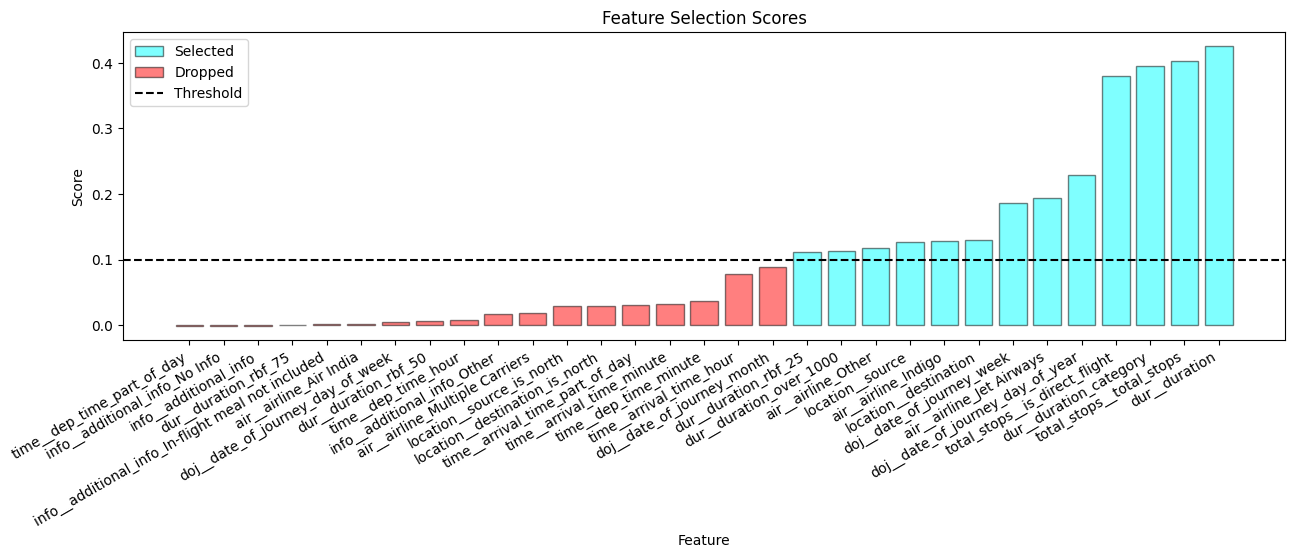

In [65]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
# colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="cyan",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

- The dataset went upto 31 columns after Feature Engineering
- The Feature Selection algorithm selected 13 features out of that